In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
train_x, classes = iris.data, iris.target

# whiten features
train_x -= np.mean(train_x, axis=0)
train_x /= np.std(train_x, axis=0) + 1e-8

# convert target to one hot vectors
train_y = np.zeros((150, 3))
train_y[np.arange(150), classes] = 1

Using TensorFlow backend.
W0331 16:09:42.784621 140577111525184 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


150/150 [==============================] - 0s 276us/step
[0.015183959665397803, 0.9933333333333333]


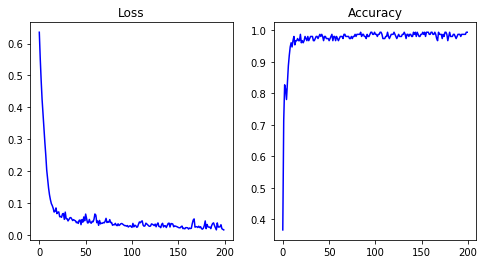

In [2]:
import keras
import keras.layers as layers
import keras.backend as K
from model import LogGaussMF


def train_model():
    model = keras.Sequential([
        layers.Dense(4, activation="relu", input_shape=(4,)),
        LogGaussMF(3),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))),
        layers.Dense(3),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.03),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=16,
        epochs=200,
        verbose=0,
        shuffle=True)
    
    print(model.evaluate(train_x, train_y))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")

    return model


model = train_model()

In [3]:
def find_representatives(model):
    pred_y = model.predict(train_x)
    
    medoid_idxs = []
    for i in range(3):
        medoid_idxs.append(np.argmax(pred_y[:,i]))
    
    return train_x[medoid_idxs]


medoids = find_representatives(model)
print(medoids)

[[-0.90068116  1.01900433 -1.34022652 -1.31544428]
 [-0.41600968 -1.51316004  0.02387172 -0.13075463]
 [ 2.49201917  1.70959461  1.50164481  1.05393501]]


In [4]:
import innvestigate
from keras.models import Model


def analyze_representative(model, representative, top_k=10):
    assert(isinstance(model.layers[-5], LogGaussMF))
    assert(isinstance(model.layers[-4], layers.Lambda))
    assert(isinstance(model.layers[-3], layers.Lambda))
    assert(isinstance(model.layers[-2], layers.Dense))
    
    # outputs needed for analyzing the network
    features_tensor = model.layers[-6].output
    memberships_tensor = model.layers[-5].output
    firing_strength_tensor = model.layers[-3].output
    logits_tensor = model.layers[-2].output
    
    # new model with the outputs from above
    analysis_model = Model(model.inputs, [
        features_tensor,
        memberships_tensor,
        firing_strength_tensor,
        logits_tensor,
    ])
    
    # compute the values of those tensors on the representative
    features, memberships, firing_strength, logits = analysis_model.predict(
        representative.reshape(1, 4))
    
    # find and output the max logit
    logit_val, logit_idx = np.max(logits), np.argmax(logits)
    print("Logits: {}".format(logits))
    print("Max Logit")
    print("Value = {}, Index = {}\n".format(logit_val, logit_idx))
    
    # find the rule that contributed most to the logit
    # this is computed as firing strength multiplied by the weights
    W = analysis_model.layers[-1].get_weights()[0]
    R = W[:,logit_idx] * firing_strength
    rule_val, rule_idx = np.max(R), np.argmax(R)
    print("Firing Strength: {}".format(firing_strength))
    print("Weights: {}".format(W[:,logit_idx]))
    print("Most important rule")
    print("Value = {}, Index = {}\n".format(rule_val, rule_idx))
    
    # the maximum membership value does not appear to be a good indicator of the
    # most important membership function. a large number of rules seem to share
    # the maximum possible value of the membership function, 1.
    mu, beta = analysis_model.layers[-4].get_weights()
    R = np.exp(memberships[:,rule_idx,:]) * features
    membership_val = np.max(R)
    membership_idx = np.argmax(R)
    print("Features: {}".format(features))
    print("Memberships: {}".format(np.exp(memberships[:,rule_idx,:])))
    print("Most important MF")
    print("Value = {}, Index = {}\n".format(membership_val, membership_idx))

    model_wo_softmax = Model(model.inputs, [model.layers[-6].output])
    analyzer = innvestigate.create_analyzer(
        "guided_backprop", 
        model_wo_softmax,
        neuron_selection_mode="index",
        allow_lambda_layers=True)

    analysis = analyzer.analyze(
        representative.reshape(1, 4),
        membership_idx).squeeze()
    
    print("Input Space Relevance")
    print(analysis)
    print("\n")
    
    
for medoid in medoids:
    analyze_representative(model, medoid, top_k=1)

Logits: [[ 5.7828636 -3.2170925 -1.8128684]]
Max Logit
Value = 5.782863616943359, Index = 0

Firing Strength: [[1.0000000e+00 1.7259994e-05 8.5967727e-10]]
Weights: [ 5.392132  -3.6712193 -4.644099 ]
Most important rule
Value = 5.392131805419922, Index = 0

Features: [[0.        5.2738085 5.669628  2.1463263]]
Memberships: [[9.6721506e-01 1.7113898e-02 1.6442398e-02 4.0941494e-08]]
Most important MF
Value = 0.09322228282690048, Index = 2

Input Space Relevance
[-4.785503  5.709118 -7.243987 -9.689416]


Logits: [[-3.4372637  3.8090193 -3.0176578]]
Max Logit
Value = 3.8090193271636963, Index = 1

Firing Strength: [[2.2176956e-04 1.0000000e+00 3.4029245e-02]]
Weights: [-2.6541252  4.4333262 -1.7830145]
Most important rule
Value = 4.433326244354248, Index = 1

Features: [[0.        0.        0.        0.9707412]]
Memberships: [[0.862349  1.        0.9993801 0.9993123]]
Most important MF
Value = 0.9700736403465271, Index = 3

Input Space Relevance
[ 0.19742776  0.35724387  2.3113203  -2.94